In [63]:
#ALL IMPORTS
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches

In [2]:
# Open files and Load DATA
sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\latestStats.json") as f:
    data = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\availableServers.json") as f:
    servers = json.load(f)


In [3]:
# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
servers_df = pd.DataFrame(servers)

# # Convert the avg_latency column to numeric and save it back to the dataframe
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
#print(type(int(servers_df['_id'][0])))
servers_df['_id'] = pd.to_numeric(servers_df['_id'])

# Convert 'hops_number' column to numeric
df['hops_number'] = pd.to_numeric(df['hops_number']).astype(int)

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))


In [4]:
# List of unique destinations in DataFrame
destinations = df['_id'].str.split('_', expand=True)[0].unique()

#sort the dataframe by hops_number
df_sorted = df.sort_values(by='hops_number')

# Get the number of unique 'hops_number' values
num_hops = len(df_sorted['hops_number'].unique())

colormap = plt.cm.get_cmap('Set1', num_hops)

# Create a dictionary to map 'hops_number' to colors
color_dict = {hops: colormap(i) for i, hops in enumerate(df_sorted['hops_number'].unique())}

df['color'] = df['hops_number'].map(color_dict)

C:\Users\maxbr\AppData\Local\Temp\ipykernel_21252\439737248.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set1', num_hops)


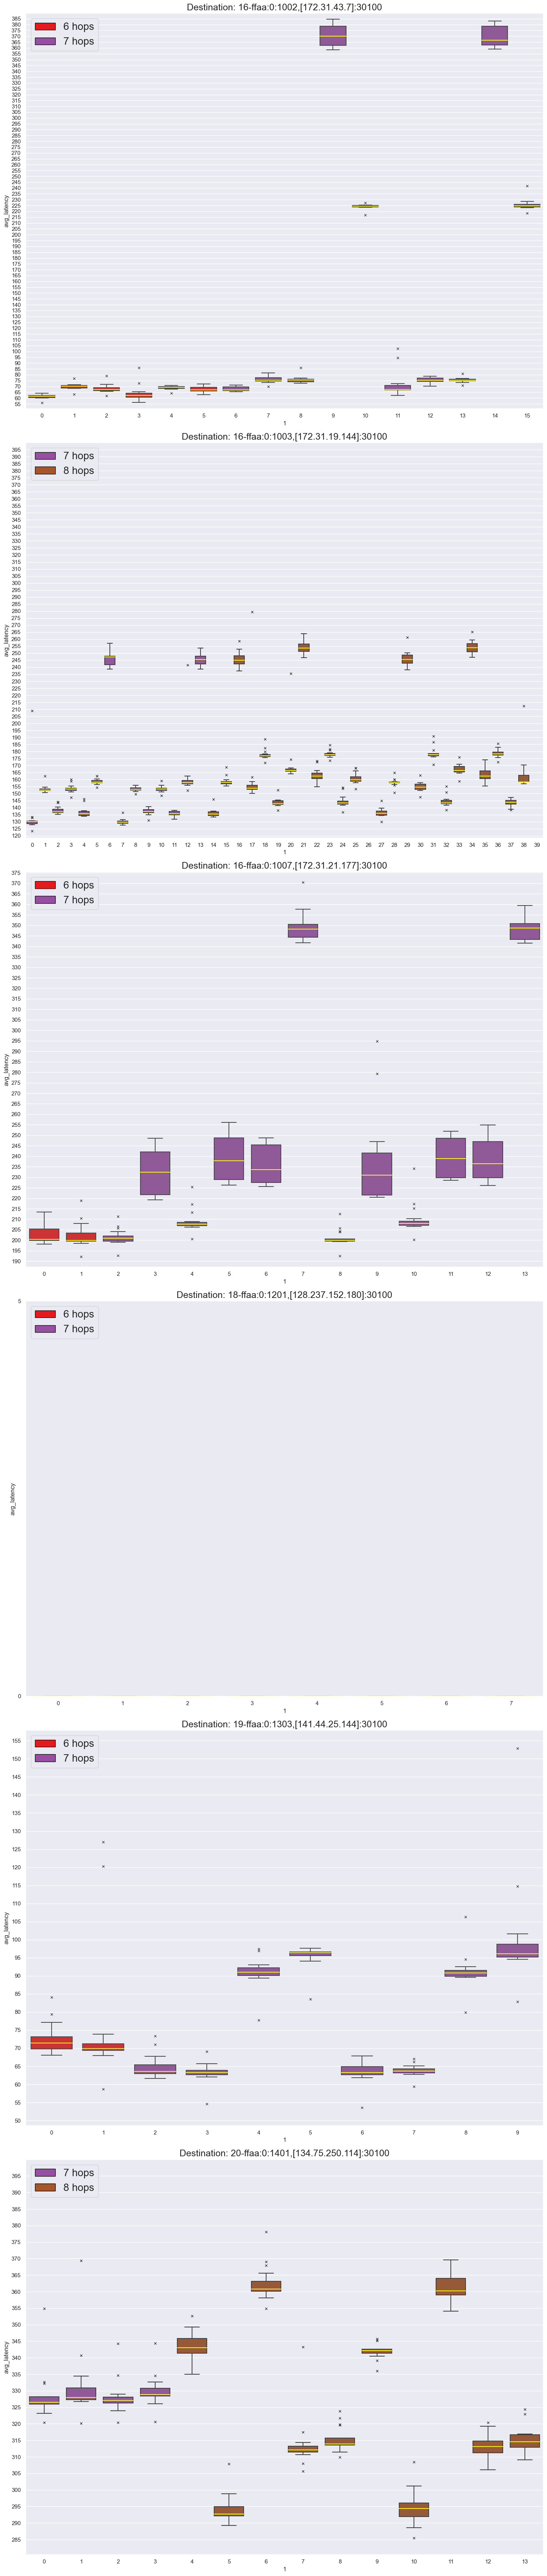

In [83]:
# # THIS IS THE CODE FOR THE PLOT OF THE AVERAGE LATENCY FOR EACH PATH FOR EACH DESTINATION. (WHISKER PLOT)

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 70))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
for i, destination in enumerate(destinations):
    ax = axes[i]  # Get the current subplot
    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Latency (ms)")
        
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops +1 
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] <= min_hops+1)]

    min_latency = data['avg_latency'].min()
    max_latency = data['avg_latency'].max()

    ax.set_ylim([max(0, min_latency-5), min(400, max_latency+5)])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]
    
    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['_id'].unique())]
    
    # Create a list of colors for each pathID in the current destination
    box_color = [data[data['_id'] == id]['color'].iloc[0] for id in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color)}

    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)
    
    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))

    ax.legend(legend_handles, legend_labels, loc='upper left', prop={'size': 20})  # Add the legend to the subplot

    ax.set_title(f"Destination: {server}", fontsize=18)  # Set the title for the subplot
        
# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

In [29]:
#Creating a dictionary with the number of destinations for each number of hops

hops_destinations = {}
list_of_hops = [i for i in range(df['hops_number'].min(), df['hops_number'].max()+1)]

for destination in destinations:
    list_of_hops_per_dest = df[df['_id'].str.startswith(destination)]['hops_number'].unique()
    for hops in list_of_hops_per_dest:
        if hops in hops_destinations:
            hops_destinations[hops] = hops_destinations.get(hops, 0) + 1
        else:
            hops_destinations[hops] = 1


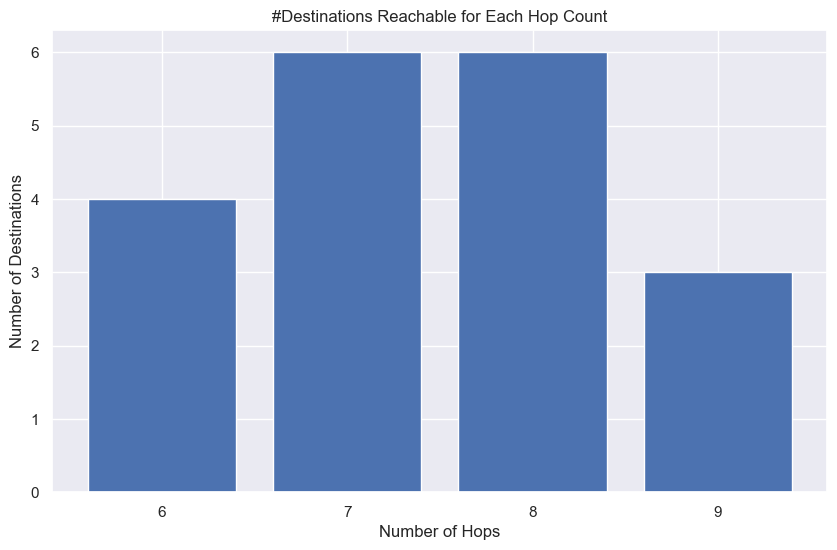

In [30]:
# Create a bar chart with #destination reachable for each hop count
plt.figure(figsize=(10, 6))
plt.bar(hops_destinations.keys(), hops_destinations.values())
plt.xticks(list_of_hops, [str(hops) for hops in list_of_hops])

# Set the labels and title
plt.xlabel('Number of Hops')
plt.ylabel('Number of Destinations')
plt.title('#Destinations Reachable for Each Hop Count')

# Show the plot
plt.show()


['17', '16']
[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)]
['17', '16', '18']
[(0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0), (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0), (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0)]
['17', '16']
[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)]
['17', '18']
[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)]
['17', '19']
[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)]
['17', '18', '20']
[(0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0), (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0), (0.596078431372549, 0.

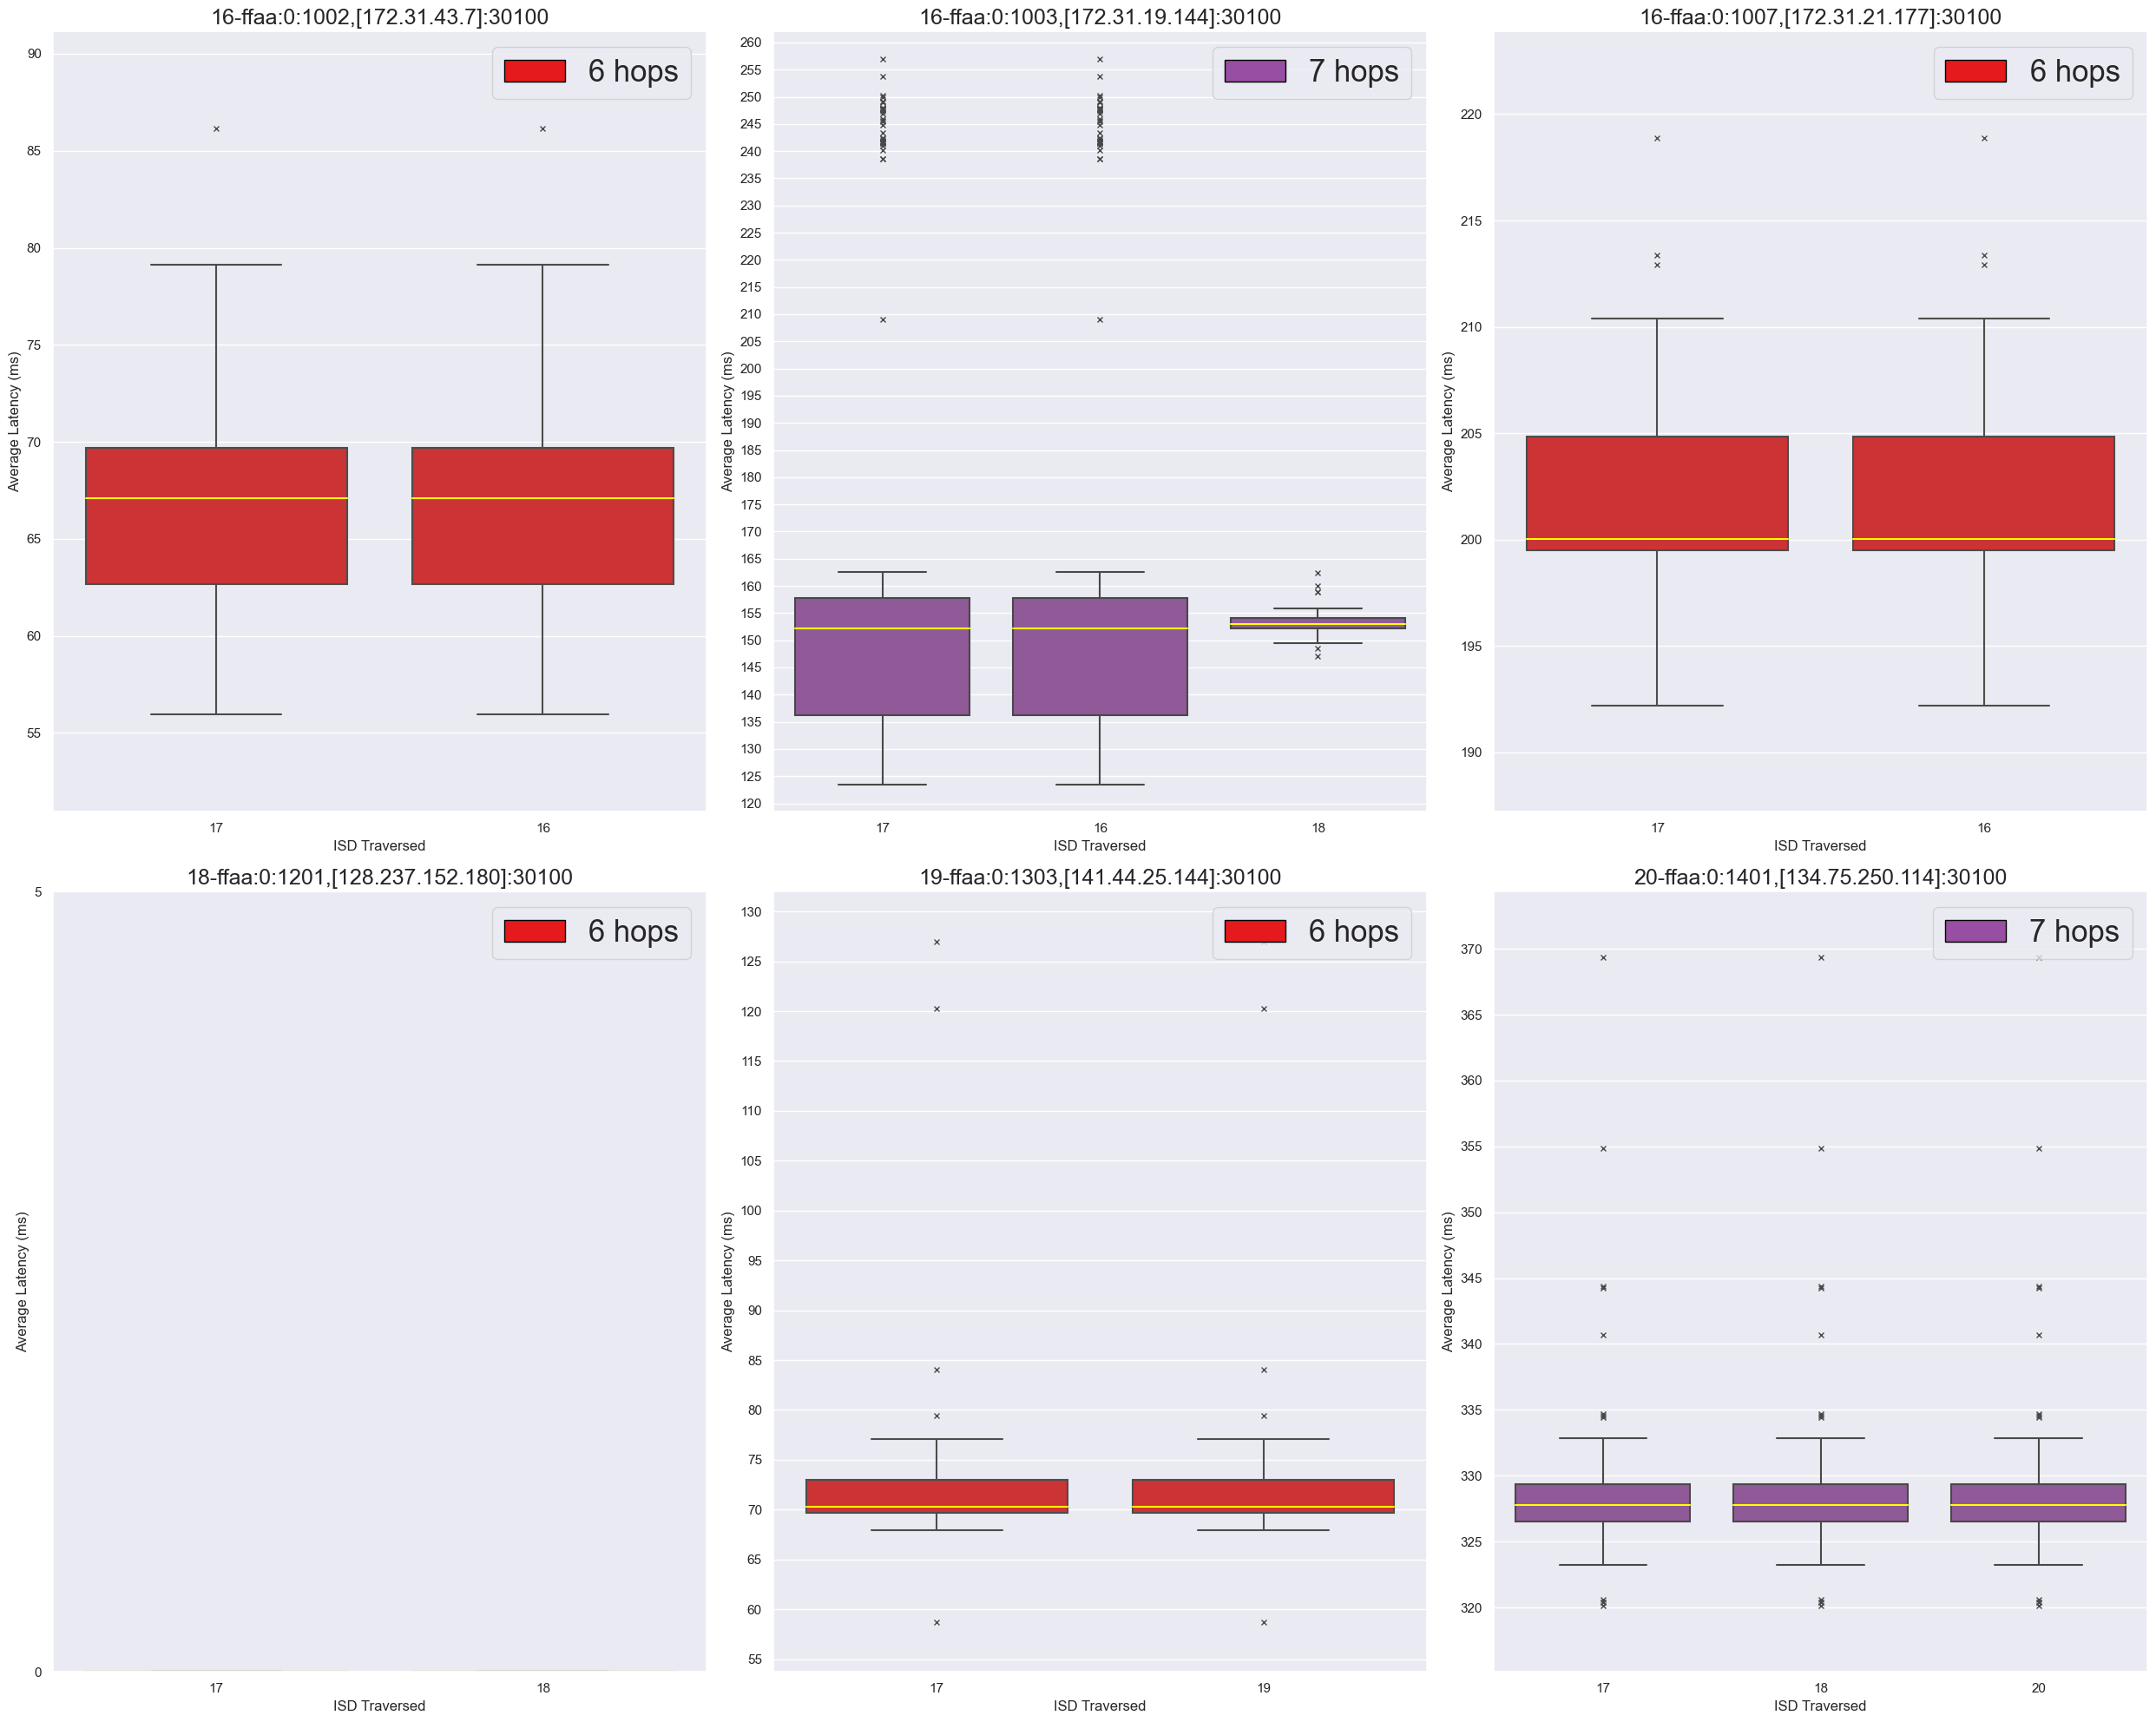

In [101]:
#Latency measured per ISD, grouped by hop count, destination fixed

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))


# Filter the DataFrame to include only the necessary columns
filtered_df = df[['_id', 'avg_latency', 'isolated_domains', 'hops_number', 'color']]
exploded_df = filtered_df.explode('isolated_domains')

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
for i, destination in enumerate(destinations):
    ax = axes[i]  # Get the current subplot
    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    
    min_hops = exploded_df[exploded_df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops 
    data = exploded_df[exploded_df['_id'].str.startswith(destination) & (exploded_df['hops_number'] == min_hops)]

    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['isolated_domains'].unique())]

    # Create a list of colors, It retrieves the color of the ISD with the minimum number of hops
    box_color = [data[data['isolated_domains'] == doamin]['color'].iloc[0] for doamin in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color) if color is not None and not data[data['color'] == color].empty}

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['isolated_domains'], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)
    
    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in color_hops_dict.keys()]

    legend_labels = [f"{min_hops} hops"]

    ax.legend(legend_handles, legend_labels, loc='upper right', prop={'size': 25})  # Add the legend to the subplot
    ax.set_xlabel("ISD Traversed")
    ax.set_ylabel("Average Latency (ms)")
    
    min_latency = data['avg_latency'].min()
    max_latency = data['avg_latency'].max()

    ax.set_ylim([max(0, min_latency-5), min(400, max_latency+5)])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    ax.set_title(f"{server}", fontsize=18)  # Set the title for the subplot

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

In [ ]:

df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''))
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''))


In [ ]:

for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, (ax, bx) = plt.subplots(1,2, figsize=(50,5))
    ax.hist(d['avg_bandwidth_cs_64'])
    ax.hist(d['avg_bandwidth_cs_MTU'], color='red')
    bx.hist(d['avg_bandwidth_sc_64'])
    bx.hist(d['avg_bandwidth_sc_MTU'], color='red')
    ax.set_title(id)

In [ ]:

for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, ax = plt.subplots(1,1, figsize=(10,5))
    ax.hist(d['avg_latency'])
    ax.set_title(id)
    # sns.violinplot(d, hue_order=[True, False], split=True, ax=ax, orient='h')
